<a href="https://colab.research.google.com/github/EsmeBarker/Collab/blob/main/EsmeBarkU2proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install preliz

Importing libraries

Installing preliz

In [3]:
import preliz as pz
import numpy as np
import arviz as az
import pymc as pm
import pandas as pd

Taylor Fritz is an American pro tennis player. I chose to look at his career stats for this project(accessed via tennisabstract.com) because I like tennis and he's American. Specifically, I was interested in how likely one of his matches is to go over 2 hours. I thought this would be an interesting statitistic to look at because tennis matches, though they have an average time, can go theoretically infinitely. The longest tennis match at Wimbledon lasted over 11 hours. Most matches aren't nearly that long, but I was interested in knowing how many matches for a pro tennis player lean on the longer side.

To keep the results somewhat useful, I only counted matches that were best of 3 six game sets, excluding any that ended in a withdrawl. Here I have pandas read the csv with data on his career matches and print the table it makes. I chose to look at his whole career because I felt like having as much data as possible was the best way to go. Note: I was not able to include matches that didn't have info about match length.

In [4]:
fritz_url = 'https://raw.githubusercontent.com/EsmeBarker/Collab/refs/heads/main/Fritz%20-%20Sheet1.csv'
fritz_data = pd.read_csv(fritz_url)
fritz_data

,Date,Tournament,Surface,Rd,Rk,vRk,Unnamed: 6,Score,DR,A%,DF%,1stIn,1st%,2nd%,BPSvd,Time
0,25‑Aug‑2014,US Open,Hard,Q1,1264,228.0,Jan Mertl [CZE] d. (WC)Fritz,1-6 6-3 6-3,0.86,5.50%,2.20%,47.30%,72.10%,43.80%,6/10,1:40
1,12‑Mar‑2015,Indian Wells Masters,Hard,Q2,941,125.0,(15)Thiemo De Bakker [NED] d. (WC)Fritz,6-4 6-4,0.71,12.50%,1.80%,64.30%,66.70%,50.00%,1/4,1:02
2,12‑Mar‑2015,Indian Wells Masters,Hard,Q1,941,109.0,(WC)Fritz d. (12)Dudi Sela [ISR],6-3 6-0,1.59,10.20%,0.00%,59.30%,82.90%,45.80%,7/7,0:58
3,4‑Jan‑2016,Happy Valley CH,Hard,F,174,100.0,(8)Fritz d. (1)Dudi Sela [ISR],7-6(7) 6-2,1.28,14.90%,4.50%,67.20%,77.80%,50.00%,3/4,1:18
4,4‑Jan‑2016,Happy Valley CH,Hard,SF,174,592.0,(8)Fritz d. (Q)Andrew Whittington [AUS],6-0 6-2,1.97,16.30%,7.00%,48.80%,81.00%,59.10%,0/0,0:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,27‑Jul‑2025,Canada Masters,Hard,R32,4,36.0,(2)Fritz d. (27)Gabriel Diallo [CAN],6-4 6-2,2.13,10.40%,0.00%,54.20%,88.50%,68.20%,1/1,1:15
504,27‑Jul‑2025,Canada Masters,Hard,R64,4,89.0,(2)Fritz d. Roberto Carballes Baena [ESP],7-5 7-6(1),1.31,10.30%,3.80%,59.00%,82.60%,46.90%,4/6,2:31
505,7‑Aug‑2025,Cincinnati Masters,Hard,R16,4,136.0,(Q)Terence Atmane [FRA] d. (4)Fritz,3-6 7-5 6-3,0.90,7.60%,2.20%,65.20%,76.70%,43.80%,3/6,1:59
506,7‑Aug‑2025,Cincinnati Masters,Hard,R32,4,36.0,(4)Fritz d. (31)Lorenzo Sonego [ITA],7-6(4) 7-5,1.65,19.70%,3.00%,56.10%,86.50%,72.40%,0/0,2:07


The average length of one of these matches is around 90 minutes. For my prior, I'll assume about 30% of matches go 2 hours or longer, because based on my amatuer tennis playing this is what I would imagine for mens pro tennis. Below is the distribution generated by my prior.

<Axes: >

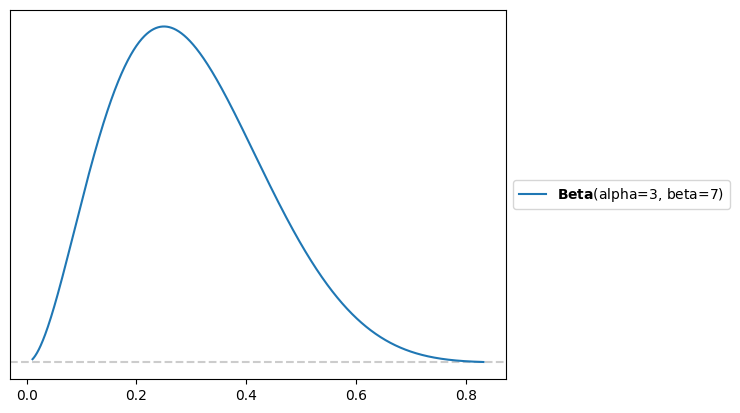

In [ ]:
pz.Beta(alpha=3,beta=7).plot_pdf()

Now, I'm going to figure out how many matches went over 2 hours in my actual data. All I actually care about is the 'Time' column, so I spliced that.

In [ ]:
fritz_time=fritz_data['Time']
fritz_time

,Time
0,1:40
1,1:02
2,0:58
3,1:18
4,0:53
...,...
503,1:15
504,2:31
505,1:59
506,2:07


Next, I need to convert this into durations that pandas can read so that I can find durations above 2 hours with a query. This part was done with the help of google AI overview and the built in gemeni editing tool on colab.

In [ ]:
fritz_minutes = pd.to_timedelta(fritz_time + ':00')
fritz_minutes


,Time
0,0 days 01:40:00
1,0 days 01:02:00
2,0 days 00:58:00
3,0 days 01:18:00
4,0 days 00:53:00
...,...
503,0 days 01:15:00
504,0 days 02:31:00
505,0 days 01:59:00
506,0 days 02:07:00


Now I can use a pandas query to find matches equal to or greater than 2 hours in length. This was also done the help of AI Overview.

In [ ]:
long_matches=fritz_minutes[fritz_minutes>=pd.Timedelta(hours=2)]
long_matches

,Time
6,0 days 02:22:00
12,0 days 02:20:00
26,0 days 02:05:00
27,0 days 02:10:00
28,0 days 02:09:00
...,...
496,0 days 02:02:00
497,0 days 03:04:00
502,0 days 02:56:00
504,0 days 02:31:00


Now I want to know how many of the 507 matches were 2+ hours.

In [ ]:
long_matches.count()

np.int64(116)

Now we'll use our prior along with a bernoulli distribution to predict 2000 more matches.

In [ ]:
LM_data = np.repeat([1,0], repeats = [116,391])
with pm.Model() as LM_model:
  #prior based on my guess
  θ = pm.Beta('θ' , alpha = 3. , beta = 10.)
  y = pm.Bernoulli('y', p = θ, observed = LM_data)
  sample_FLM = pm.sample(2000)

We can plot these 2000 matches sampled from the model of the posterior to see the most likely percentage chance of one of Fritz's matches going over 2 hours

<Axes: title={'center': 'θ'}>

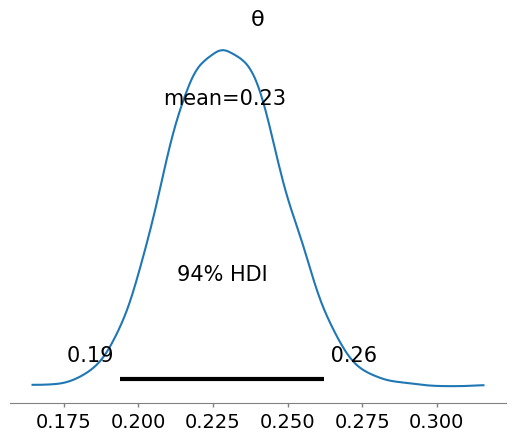

In [10]:
az.plot_posterior(sample_FLM)

23%. This is reasonably close to my prior, and a believable statistic. I think this makes sense. I didn't have the best idea of what the percentage would be but I knew it would be on the less likely side, but not insanely unlikely.

Though the statistic seems reasonable, I don't think this model was great. It weighted all of his matches equally, even the ones from 5+ years ago, and he's probably changed as a player since then. I also didn't account for different types of courts(hard, grass, etc.) which is an issue because different types of courts can speed up or slow down a match.